## QAOA for MAXCUT

Here we follow an altered tutorial for maxcut below:
https://qiskit.org/textbook/ch-applications/qaoa.html
Then we will try to test how the parameters passed in to qaoa affect the energy of a graph
--energy defined as the cost function evaluated in qaoa for p=1

In [54]:
#modified from https://github.com/Chriz91/qaoa-max-cut
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import nlopt
import networkx as nx
import qiskit
from qiskit import BasicAer
from qiskit.optimization.ising import max_cut
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.optimizers.nlopts.esch import ESCH
from qiskit.aqua.algorithms import QAOA
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators.weighted_pauli_operator import WeightedPauliOperator
import pandas as pd

In [12]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.12.0',
 'qiskit-aer': '0.4.1',
 'qiskit-ignis': '0.2.0',
 'qiskit-ibmq-provider': '0.5.0',
 'qiskit-aqua': '0.6.4',
 'qiskit': '0.16.1'}

/Users/victorli/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


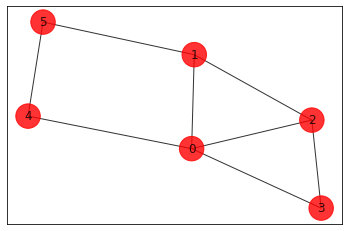

In [13]:
n = 6  # Number of nodes in graph
G = nx.Graph()
G.add_nodes_from(np.arange(0, n, 1))
elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (0, 4, 1.0), (1, 2, 1.0), (1, 5, 1.0), (4, 5, 1.0), (2, 3, 1.0)]
G.add_weighted_edges_from(elist)

colors = ['r' for node in G.nodes()]
pos = nx.spring_layout(G)
default_axes = plt.axes(frameon=True)
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.8, ax=default_axes, pos=pos)
plt.show()

In [14]:
w = np.zeros([n, n])
for i in range(n):
    for j in range(n):
        temp = G.get_edge_data(i, j, default=0)
        if temp != 0:
            w[i, j] = temp['weight']

print("weight matrix")
print(w)

weight matrix
[[0. 1. 1. 1. 1. 0.]
 [1. 0. 1. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0.]
 [1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 1. 0.]]


In [15]:
best_cost_brute = 0
for b in range(2**n):
    x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
    cost = 0
    for i in range(n):
        for j in range(n):
            cost = cost + w[i, j]*x[i]*(1-x[j])
    if best_cost_brute < cost:
        best_cost_brute = cost
        xbest_brute = x
    #print('case = ' + str(x) + ' cost = ' + str(cost))

print('\nBest solution = ' + str(xbest_brute) + ' cost = ' + str(best_cost_brute))

#NOTE THAT [1,0,1,0,0,1] IS AN EQUIVALENTLY GOOD PARTITION, so we hope to evolve into the subspace
#spanned by 101001 and 010110


Best solution = [0, 1, 0, 1, 1, 0] cost = 7.0


In [28]:
#Converts adjacency matrix into a list of Pauli z operators (idk what the x part does)
#xp is here to make sure there is no complex component in pauli generated and that it is strictly z
num_nodes = w.shape[0]
pauli_list = []
for i in range(num_nodes):
    for j in range(i):
        if w[i, j] != 0:
            xp = np.zeros(num_nodes, dtype=np.bool)
            zp = np.zeros(num_nodes, dtype=np.bool)
            zp[i] = True
            zp[j] = True
            pauli_list.append([0.5 * w[i, j], Pauli(zp, xp)])
qubitOp = WeightedPauliOperator(paulis=pauli_list)
#print(qubitOp.paulis)

In [46]:
#Note from above, our goal is to maximum 1/2 - 1/2*sum(z_i*z_j) but we are equivalently minimizing 1/2*sum(z_i*z_j)
#Therefore the true energy is 1/2 - (calculated min energy)

n_shots = 512
p_steps = 1

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=n_shots)

qaoa = QAOA(qubitOp, ESCH(max_evals=100), p=p_steps+8)
result = qaoa.run(quantum_instance)
#State-vectors in result are written LSB (0th vertex is last qubit)
print(result)

solution = max_cut.sample_most_likely(result['eigvecs'][0]) #returns vector with highest counts
print('energy:', result['energy'])
print('time:', result['eval_time'])
#print('solution:', max_cut.get_graph_solution(x)) #inverts string - idk why this is needed
print('solution:', solution)
print('optimal parameters', result['opt_params'])
#9 params are the beta and gamma

{'num_optimizer_evals': 100, 'min_val': -0.966796875, 'opt_params': array([1.91748357, 0.41713172, 1.66758152, 0.01450238, 0.16736141,
       0.01172316, 2.11574651, 0.16446149, 1.14544705, 3.57374789,
       0.31270954, 2.87762134, 0.36740155, 1.72085939, 3.64222932,
       0.20051554, 0.35610368, 0.1646642 ]), 'eval_time': 7.944586992263794, 'eval_count': 100, 'energy': -0.966796875, 'eigvals': array([-0.96679688]), 'min_vector': {'010101': 14, '101011': 10, '011011': 1, '010010': 4, '000101': 1, '011100': 49, '101101': 6, '111101': 8, '011101': 6, '011001': 2, '101110': 3, '001011': 2, '010011': 17, '101001': 2, '001100': 13, '111011': 13, '111111': 1, '111100': 10, '000011': 13, '011010': 57, '000010': 3, '110100': 1, '001111': 10, '100110': 1, '111001': 1, '100001': 12, '100011': 56, '101100': 21, '101010': 24, '010110': 5, '010100': 17, '101000': 1, '100000': 3, '110010': 1, '100100': 2, '100010': 13, '011000': 3, '110101': 4, '110000': 5, '100111': 3, '000100': 8, '111010': 2, '

/Users/victorli/anaconda3/lib/python3.7/site-packages/qiskit/optimization/ising/max_cut.py:117: DeprecationWarning: sample_most_likely function has been moved to qiskit.optimization.ising.common, the method here will be removed after Aqua 0.7+
  DeprecationWarning)


/Users/victorli/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


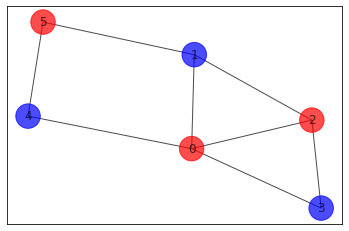

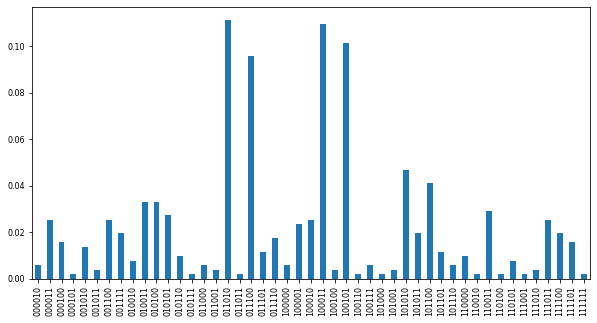

In [48]:
#min vec 011010, solutio 010110, graph 100101
colors = ['r' if solution[i] == 0 else 'b' for i in range(n)]
nx.draw_networkx(G, node_color=colors, node_size=600, alpha=.7, pos=pos)
plt.show()
df = pd.DataFrame.from_dict(result['min_vector'], orient='index') / n_shots
df = df.sort_index()
barplot = df.plot.bar(legend=False, figsize=(10, 5), fontsize=8)
plt.show() #as you can see, the reversed solution 011010 is the most common

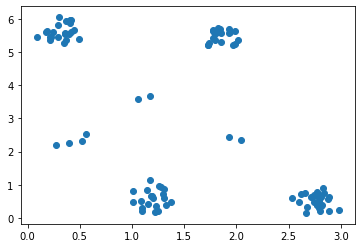

In [56]:
#how do parameters, maximizing states, minimum energy (maximum for the true cost function as explained a couple cells above) 
n_shots = 512
p_steps = 1

backend_same_graph = BasicAer.get_backend('qasm_simulator')
quantum_instance_same_graph = QuantumInstance(backend_same_graph, shots=n_shots)

opt_params_same_graph = []
opt_energies_same_graph = []
opt_states_same_graph = []
for i in range(100):
    qaoa_same_graph = QAOA(qubitOp, ESCH(max_evals=80), p=p_steps)
    result_same_graph = qaoa_same_graph.run(quantum_instance_same_graph)
    opt_params_same_graph.append(result_same_graph['opt_params'])
    opt_energies_same_graph.append(result_same_graph['energy'])
    opt_states_same_graph.append(max_cut.sample_most_likely(result_same_graph['eigvecs'][0]))

param_data_same_graph = np.array(opt_params_same_graph).T
plt.scatter(param_data_same_graph[0], param_data_same_graph[1])
plt.show()

In [57]:
result_table_same_graph = pd.DataFrame(data = {"Beta":param_data_same_graph[0], "Gamma":param_data_same_graph[1],
                            "State":opt_states_same_graph, "Energy": .5-np.array(opt_energies_same_graph)})
result_table_same_graph.head()

,Beta,Gamma,State,Energy
0,2.785082,0.733787,"[0, 1, 0, 1, 1, 0]",1.816406
1,1.144202,0.840414,"[1, 0, 1, 0, 0, 1]",1.527344
2,1.252504,0.215405,"[1, 0, 1, 0, 0, 1]",1.191406
3,2.843253,0.763386,"[1, 0, 1, 0, 0, 1]",1.796875
4,2.880661,0.571900,"[0, 1, 0, 1, 1, 0]",1.626953


/Users/victorli/anaconda3/lib/python3.7/site-packages/qiskit/optimization/ising/max_cut.py:117: DeprecationWarning: sample_most_likely function has been moved to qiskit.optimization.ising.common, the method here will be removed after Aqua 0.7+
  DeprecationWarning)


energy: -0.3125
time: 0.08076000213623047
solution: [1 0 1 0 0 1]
optimal parameters [2. 5.]


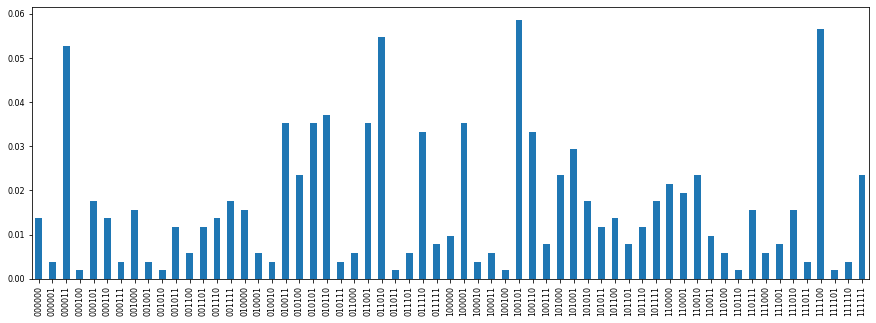

In [21]:
n_shots = 512
p_steps = 1

backend = BasicAer.get_backend('qasm_simulator')
quantum_instance = QuantumInstance(backend, shots=n_shots)

qaoa = QAOA(qubitOp, ESCH(max_evals=1), p=p_steps, initial_point = [2, 5])
result = qaoa.run(quantum_instance)
#State-vectors in result are written LSB (0th vertex is last qubit)
#print(result)

solution = max_cut.sample_most_likely(result['eigvecs'][0]) #returns vector with highest counts
print('energy:', result['energy'])
print('time:', result['eval_time'])
#print('solution:', max_cut.get_graph_solution(x)) #inverts string - idk why this is needed
print('solution:', solution)
print('optimal parameters', result['opt_params'])
df = pd.DataFrame.from_dict(result['min_vector'], orient='index') / n_shots
df = df.sort_index()
barplot = df.plot.bar(legend=False, figsize=(15, 5), fontsize=8)
plt.show()